In [1]:
import pandas as pd
import numpy as np
import iisignature 
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
#If you haven't install iisignature,use the code:   pip install iisignature


 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Load the dataset
stock_data = pd.read_csv("stock_details_5_years.csv")


In [3]:
#Parsing the date
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.tz_localize(None).dt.date

In [9]:
#Calculating daily returns
stock_data['Return'] = stock_data.groupby('Company')['Close'].pct_change()
stock_data['OReturn'] = stock_data.groupby('Company')['Open'].pct_change()
stock_data.dropna(subset=['Return'], inplace=True)
stock_data.dropna(subset=['OReturn'], inplace=True)








In [10]:
#Delete useless company
target_date = pd.Timestamp('2022-02-01')
valid_companies = stock_data.loc[stock_data['Date'] == target_date, 'Company'].unique()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [11]:
#Retain company data that exists on the target date
stock_data = stock_data[stock_data['Company'].isin(valid_companies)]


In [12]:
#Data for simulate
start_date = pd.Timestamp('2022-02-01')
end_date = pd.Timestamp('2022-08-04')

#Get data for a specific time period
simulate_stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]








In [13]:
unique_dates_count = simulate_stock_data['Date'].nunique()
print(unique_dates_count)

unique_companys_count = simulate_stock_data['Company'].nunique()
print(unique_companys_count)


128
486


In [14]:
#Calculate mean &std of data
company_stats_C = simulate_stock_data.groupby('Company')['Return'].agg(['mean', 'std']).rename(columns={'mean': 'cmiu', 'std': 'csigma'})
company_stats_O = simulate_stock_data.groupby('Company')['OReturn'].agg(['mean', 'std']).rename(columns={'mean': 'omiu', 'std': 'osigma'})


#Simulate the return and open return
np.random.seed(2024)
simulate_stock_data = simulate_stock_data.merge(company_stats_C, on='Company')
simulate_stock_data['sim_creturn'] = simulate_stock_data.apply(
    lambda row: np.mean([np.random.normal(row['cmiu'], row['csigma']) for _ in range(100)]), axis=1
)
simulate_stock_data = simulate_stock_data.drop(columns=['cmiu', 'csigma'])


np.random.seed(2024)
simulate_stock_data = simulate_stock_data.merge(company_stats_O, on='Company')
simulate_stock_data['sim_oreturn'] = simulate_stock_data.apply(
    lambda row: np.mean([np.random.normal(row['omiu'], row['osigma']) for _ in range(100)]), axis=1
)
simulate_stock_data = simulate_stock_data.drop(columns=['omiu', 'osigma'])

simulate_stock_data['sim_Close'] = np.nan
simulate_stock_data['sim_Open'] = np.nan


# Sort the data by Company and Date
simulate_stock_data = simulate_stock_data.sort_values(by=['Company', 'Date'])

# Function to calculate simulated close and open prices
def calculate_sim(group):
    group = group.sort_values(by='Date').reset_index(drop=True)
    for i in range(len(group)):
        if i == 0:
            group.at[i, 'sim_Close'] = group.at[i, 'Close'] * (1 + group.at[i, 'sim_creturn'])
            group.at[i, 'sim_Open'] = group.at[i, 'Open'] * (1 + group.at[i, 'sim_oreturn'])
        else:
            group.at[i, 'sim_Close'] = group.at[i - 1, 'sim_Close'] * (1 + group.at[i, 'sim_creturn'])
            group.at[i, 'sim_Open'] = group.at[i - 1, 'sim_Open'] * (1 + group.at[i, 'sim_oreturn'])
    return group

# Apply the function to each group of companies
simulate_stock_data = simulate_stock_data.groupby('Company').apply(calculate_sim).reset_index(drop=True)


In [15]:
simulate_stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,Return,OReturn,sim_creturn,sim_oreturn,sim_Close,sim_Open
0,2022-02-01,138.838766,139.569866,136.783796,139.332748,1655900,0.0,0.0,A,0.012274,0.023376,-0.002025,-0.001773,139.050624,138.592615
1,2022-02-02,139.293248,143.017866,139.085768,142.504135,1475700,0.0,0.0,A,0.022761,0.003273,-0.000156,-0.000010,139.028952,138.591163
2,2022-02-03,140.291067,142.049644,139.312976,140.083588,914300,0.0,0.0,A,-0.016986,0.007163,0.001712,0.001751,139.266928,138.833785
3,2022-02-04,139.777345,140.636885,137.989130,139.421677,1087400,0.0,0.0,A,-0.004725,-0.003662,0.000776,0.000868,139.375023,138.954352
4,2022-02-07,139.797100,140.775191,138.127436,138.680695,1444100,0.0,0.0,A,-0.005315,0.000141,-0.003783,-0.003431,138.847824,138.477669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62203,2022-07-29,180.170174,180.842607,177.895795,180.516281,1752000,0.0,0.0,ZTS,0.001536,0.025151,0.001394,0.001882,174.236840,186.355193
62204,2022-08-01,178.983537,180.091054,177.342027,177.737579,1243500,0.0,0.0,ZTS,-0.015393,-0.006586,-0.003280,-0.002855,173.665316,185.823109
62205,2022-08-02,177.816699,179.537305,175.631313,176.837723,1180200,0.0,0.0,ZTS,-0.005063,-0.006519,-0.000946,-0.000489,173.501092,185.732206
62206,2022-08-03,177.638728,178.835254,176.432318,178.152939,1659900,0.0,0.0,ZTS,0.007437,-0.001001,-0.000496,-0.000033,173.415046,185.725998


In [16]:
# Def fuc to calculate signature 
def calculate_signature(data):
    company = data['Company'].iloc[0]
    date = data['Date'].iloc[0]
    company_data = simulate_stock_data[(simulate_stock_data['Company'] == company) & (simulate_stock_data['Date'] <= date)]
    if len(company_data) > 0:
        close_values = company_data['sim_Close'].values.reshape(-1, 1)  #Convert to a 2D array
        volume_values = company_data['sim_Open'].values.reshape(-1, 1)   #Convert to a 2D array
        #Compute first-order and second-order signatures
        signature_close_1 = iisignature.sig(close_values, 1)
        signature_volume_1 = iisignature.sig(volume_values, 1)
        signature_close_2 = iisignature.sig(close_values, 2)
        signature_volume_2 = iisignature.sig(volume_values, 2)
        #Concatenate signature data
        signature = np.concatenate((signature_close_1, signature_volume_1, signature_close_2, signature_volume_2), axis=None)
        return pd.Series({'Signature': signature})
    else:
        return pd.Series({'Signature': (0,0,0,0,0,0)})

#Calculate the signature
signatures = simulate_stock_data.groupby(['Company', 'Date']).apply(calculate_signature)
simulate_stock_data = simulate_stock_data.merge(signatures, left_on=['Company', 'Date'], right_index=True)


In [17]:
#Change 1 col into 6
simulate_stock_data[['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']] = pd.DataFrame(simulate_stock_data['Signature'].tolist(), index=simulate_stock_data.index)

#Delete old col
simulate_stock_data = simulate_stock_data.drop(columns=['Signature'])




In [18]:
simulate_stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,Return,...,sim_creturn,sim_oreturn,sim_Close,sim_Open,Signature1,Signature2,Signature3,Signature4,Signature5,Signature6
0,2022-02-01,138.838766,139.569866,136.783796,139.332748,1655900,0.0,0.0,A,0.012274,...,-0.002025,-0.001773,139.050624,138.592615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2022-02-02,139.293248,143.017866,139.085768,142.504135,1475700,0.0,0.0,A,0.022761,...,-0.000156,-0.000010,139.028952,138.591163,-0.021671,-0.001452,-0.021671,0.000235,-0.001452,0.000001
2,2022-02-03,140.291067,142.049644,139.312976,140.083588,914300,0.0,0.0,A,-0.016986,...,0.001712,0.001751,139.266928,138.833785,0.216305,0.241170,0.216305,0.023394,0.241170,0.029082
3,2022-02-04,139.777345,140.636885,137.989130,139.421677,1087400,0.0,0.0,A,-0.004725,...,0.000776,0.000868,139.375023,138.954352,0.324399,0.361737,0.324399,0.052617,0.361737,0.065427
4,2022-02-07,139.797100,140.775191,138.127436,138.680695,1444100,0.0,0.0,A,-0.005315,...,-0.003783,-0.003431,138.847824,138.477669,-0.202800,-0.114947,-0.202800,0.020564,-0.114947,0.006606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62203,2022-07-29,180.170174,180.842607,177.895795,180.516281,1752000,0.0,0.0,ZTS,0.001536,...,0.001394,0.001882,174.236840,186.355193,-21.522036,-11.580827,-21.522036,231.599006,-11.580827,67.057781
62204,2022-08-01,178.983537,180.091054,177.342027,177.737579,1243500,0.0,0.0,ZTS,-0.015393,...,-0.003280,-0.002855,173.665316,185.823109,-22.093560,-12.112911,-22.093560,244.062687,-12.112911,73.361306
62205,2022-08-02,177.816699,179.537305,175.631313,176.837723,1180200,0.0,0.0,ZTS,-0.005063,...,-0.000946,-0.000489,173.501092,185.732206,-22.257784,-12.203814,-22.257784,247.704468,-12.203814,74.466537
62206,2022-08-03,177.638728,178.835254,176.432318,178.152939,1659900,0.0,0.0,ZTS,0.007437,...,-0.000496,-0.000033,173.415046,185.725998,-22.343830,-12.210023,-22.343830,249.623376,-12.210023,74.542328


In [27]:
#Extract true values
true_y = simulate_stock_data[simulate_stock_data['Date'] == pd.Timestamp('2022-08-04').date()][['Company', 'sim_Close']].rename(columns={'sim_Close': 'true_y'})

#Lasso regression for each company
results = []

for company in valid_companies:
    company_data = simulate_stock_data[simulate_stock_data['Company'] == company]
    
    train_x = company_data[(company_data['Date'] >= pd.Timestamp('2022-02-01').date()) & (company_data['Date'] <= pd.Timestamp('2022-08-02').date())][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    train_y = company_data[(company_data['Date'] >= pd.Timestamp('2022-02-03').date()) & (company_data['Date'] <= pd.Timestamp('2022-08-03').date())]['sim_Close']
    
    #Ensure train_x and train_y are aligned
    train_x = train_x.iloc[1:].reset_index(drop=True)
    train_y = train_y.reset_index(drop=True)
    
    #Perform LassoCV
    lasso = LassoCV(cv=5, random_state=2024)
    lasso.fit(train_x, train_y)
    
    #Predict the value
    test_x = company_data[company_data['Date'] == pd.Timestamp('2022-08-03').date()][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    predict_y = lasso.predict(test_x)[0]
    
    results.append({'Company': company, 'predicted_y': predict_y})

#Create results DataFrame
results_df = pd.DataFrame(results)

#Merge true values with predictions
sim_result = true_y.merge(results_df, on='Company')



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.120762981673181, tolerance: 0.0998533460307293
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1573731040929225, tolerance: 0.0998533460307293
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.072e+00, tolerance: 8.761e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-package

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03417743180391142, tolerance: 0.033574651125011304
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03859373347702455, tolerance: 0.033574651125011304
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0410780335781018, tolerance: 0.033574651125011304
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_desc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9953756504492048, tolerance: 0.9026713145819826
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9110127932672185, tolerance: 0.9026713145819826
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09060362312322923, tolerance: 0.07896733812038033
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013879961715129063, tolerance: 0.009978627478300046
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04758166819524501, tolerance: 0.0292553485737982
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6211320980634127, tolerance: 0.35107502665202156
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.119e-01, tolerance: 1.107e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.026e+01, tolerance: 8.192e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0565405536476646, tolerance: 0.9809082349711502
  model = cd_fast.enet_coordinate_descen

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.62858297699859, tolerance: 50.43291728980978
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.88175179054087, tolerance: 50.43291728980978
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.31204553039424, tolerance: 50.43291728980978
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: Co

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.141e-02, tolerance: 8.890e-03
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7411520394186937, tolerance: 1.9387018636379085
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e+01, tolerance: 1.981e+00
  model = cd_fast.enet_coordinate_d

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e-01, tolerance: 5.318e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2452085094786156, tolerance: 0.21166709893068716
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24634653954868213, tolerance: 0.17603807621722856
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-pac

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.122e-02, tolerance: 3.295e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19182168548059764, tolerance: 0.18496228616974844
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.417661644337727, tolerance: 0.3542743101483199
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05394899987571833, tolerance: 0.048798429930446155
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08100588564444089, tolerance: 0.048798429930446155
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00861001722864252, tolerance: 0.008518896391683671
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_des

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01429007632526691, tolerance: 0.013010628001080549
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015947442622302077, tolerance: 0.013010628001080549
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017274556208462855, tolerance: 0.013010628001080549
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_d

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 6.839e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e-02, tolerance: 1.490e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11471238772193715, tolerance: 0.10149697493436685
  model = cd_fast.enet_coordinate_desc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9874790765244654, tolerance: 0.5620286898304008
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2998831151414834, tolerance: 0.5620286898304008
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5138536265563687, tolerance: 0.5620286898304008
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.350e+00, tolerance: 1.103e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.998e-03, tolerance: 3.305e-03
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.872e-05, toleranc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9638973002529383, tolerance: 0.8396947843131671
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.709e-01, tolerance: 1.430e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.048e-01, tolerance: 6.032e-02
  model = cd_fast.enet_coordinate_d

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.520e-02, tolerance: 5.594e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.952e-01, tolerance: 1.584e-01
  model = cd_fast.enet_coordinate_descent(


In [28]:
#Calcilate difference
sim_result["difference"] = (sim_result["true_y"] - sim_result["predicted_y"]).abs()
sim_result["difference_percentage"] = (sim_result["difference"] / sim_result["true_y"]) * 100

#Sort by difference
sim_result_sorted = sim_result.sort_values(by="difference")


#Print first and last 10 lines
print("10 lines with lowest difference:")
print(sim_result_sorted.head(10))

# 打印后十行
print("\n 10 lines with highest difference:")
print(sim_result_sorted.tail(10))


10 lines with lowest difference:
    Company      true_y  predicted_y  difference  difference_percentage
149     ECL  173.956123   173.955566    0.000557               0.000320
280     MFG    2.388753     2.389383    0.000630               0.026381
237    ITUB    4.495631     4.496757    0.001126               0.025054
372     RTX   92.949928    92.951982    0.002054               0.002209
445     UMC    6.505997     6.503862    0.002135               0.032817
1      AAPL  170.921528   170.918882    0.002646               0.001548
49     BBVA    4.519849     4.517050    0.002799               0.061920
3      ABEV    2.628722     2.631926    0.003203               0.121854
164      ET   10.236193    10.232711    0.003482               0.034014
265     LYG    2.187868     2.184081    0.003787               0.173106

 10 lines with highest difference:
    Company       true_y  predicted_y  difference  difference_percentage
61      BLK   694.573642   686.833725    7.739916               1.

In [29]:
#Calculate overall R² score
overall_r2_score = r2_score(sim_result['true_y'], sim_result['predicted_y'])
print(f"R² score: {overall_r2_score}")

R² score: 0.9999498697353915


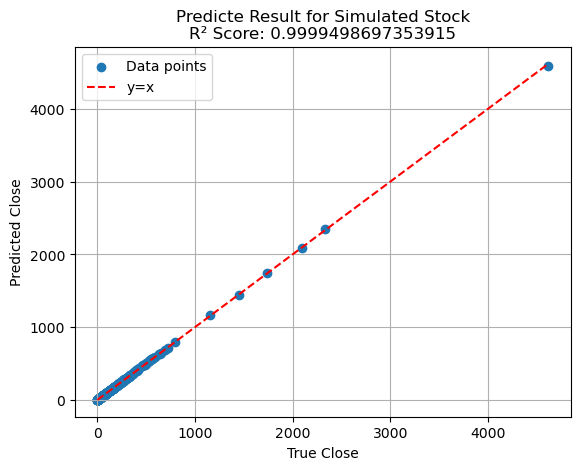

In [30]:
#Plot
plt.scatter(sim_result['true_y'], sim_result['predicted_y'], label='Data points')
plt.xlabel('True Close')
plt.ylabel('Predicted Close')
plt.title(f'Predicte Result for Simulated Stock\nR² Score: {overall_r2_score}')

plt.plot([sim_result['true_y'].min(), sim_result['true_y'].max()], [sim_result['true_y'].min(), sim_result['true_y'].max()], 'r--', label='y=x')
plt.legend()
plt.grid(True)
plt.show()